In [134]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from gensim.downloader import load
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens
from gensim.models import Word2Vec

In [135]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [136]:
print(file.loc[file[0]=='They have THE BEST tortillas too. Made right in front of you. Mmmmmm!'])

                                                        0           1  \
264     They have THE BEST tortillas too. Made right i...     neutral   
23540   They have THE BEST tortillas too. Made right i...     neutral   
73369   They have THE BEST tortillas too. Made right i...  admiration   
86008   They have THE BEST tortillas too. Made right i...  admiration   
115605  They have THE BEST tortillas too. Made right i...    approval   

               2  
264      neutral  
23540    neutral  
73369   positive  
86008   positive  
115605  positive  


In [137]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [138]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [139]:
# print(emotion)
# emotion_list = list(emotion_frequency)
# pdP = pd.Series(emotion_list)
# print(pdP.describe())

In [140]:
# print(sentiment)
# sentiment_list = list(sentiment_frequency)
# pdP = pd.Series(sentiment_list) 
# print(pdP.describe())

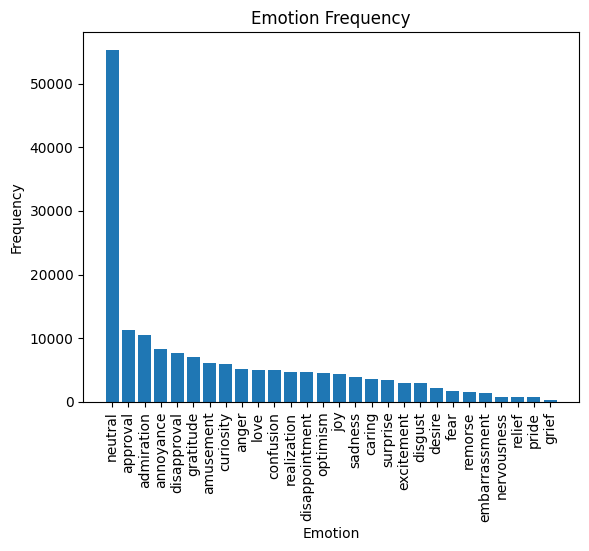

In [141]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()

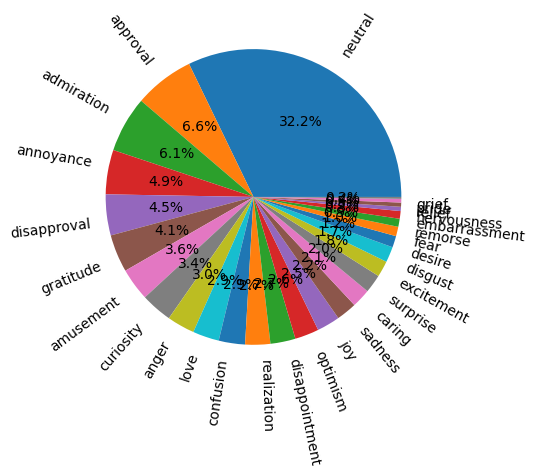

In [142]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


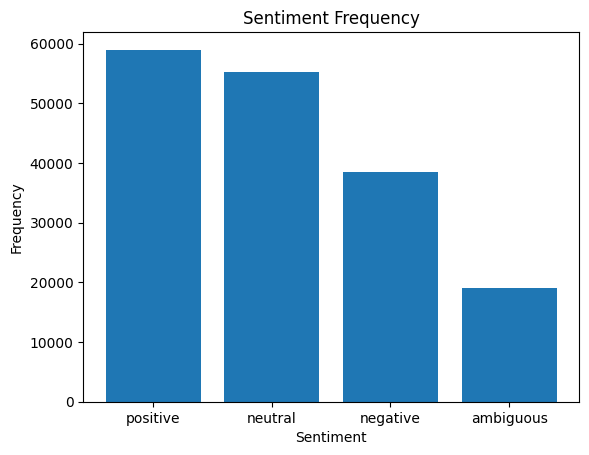

In [143]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

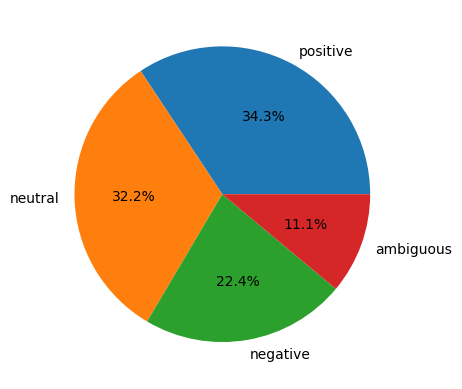

In [144]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [145]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [146]:
#print(f"The number of unique words is {len(X.toarray()[0])} unique words")

Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [147]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [148]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [149]:
print(len(yemo_train))

137456


In [150]:
def metrics(true_y,prediction_y):
    print(f"Accuracy: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted): {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted): {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro): {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [151]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Score for Emotion: 0.4339424979629845
Accuracy: 0.4339424979629845
Precision (Weighted): 0.48286212527771666
F1 Score (Weighted): 0.36753249737335647
F1 Score (Macro): 0.22398800951139192
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      2138
           1       0.63      0.38      0.47      1199
           2       0.50      0.18      0.26       970
           3       0.44      0.15      0.22      1745
           4       0.44      0.17      0.24      2281
           5       0.42      0.09      0.15       659
           6       0.58      0.10      0.17      1049
           7       0.58      0.18      0.27      1162
           8       0.62      0.06      0.11       435
           9       0.49      0.07      0.12       933
          10       0.45      0.14      0.22      1529
          11       0.63      0.13      0.22       581
          12       0.67      0.02      0.04       284
          13       0.54      0.08      0.14       612
 

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

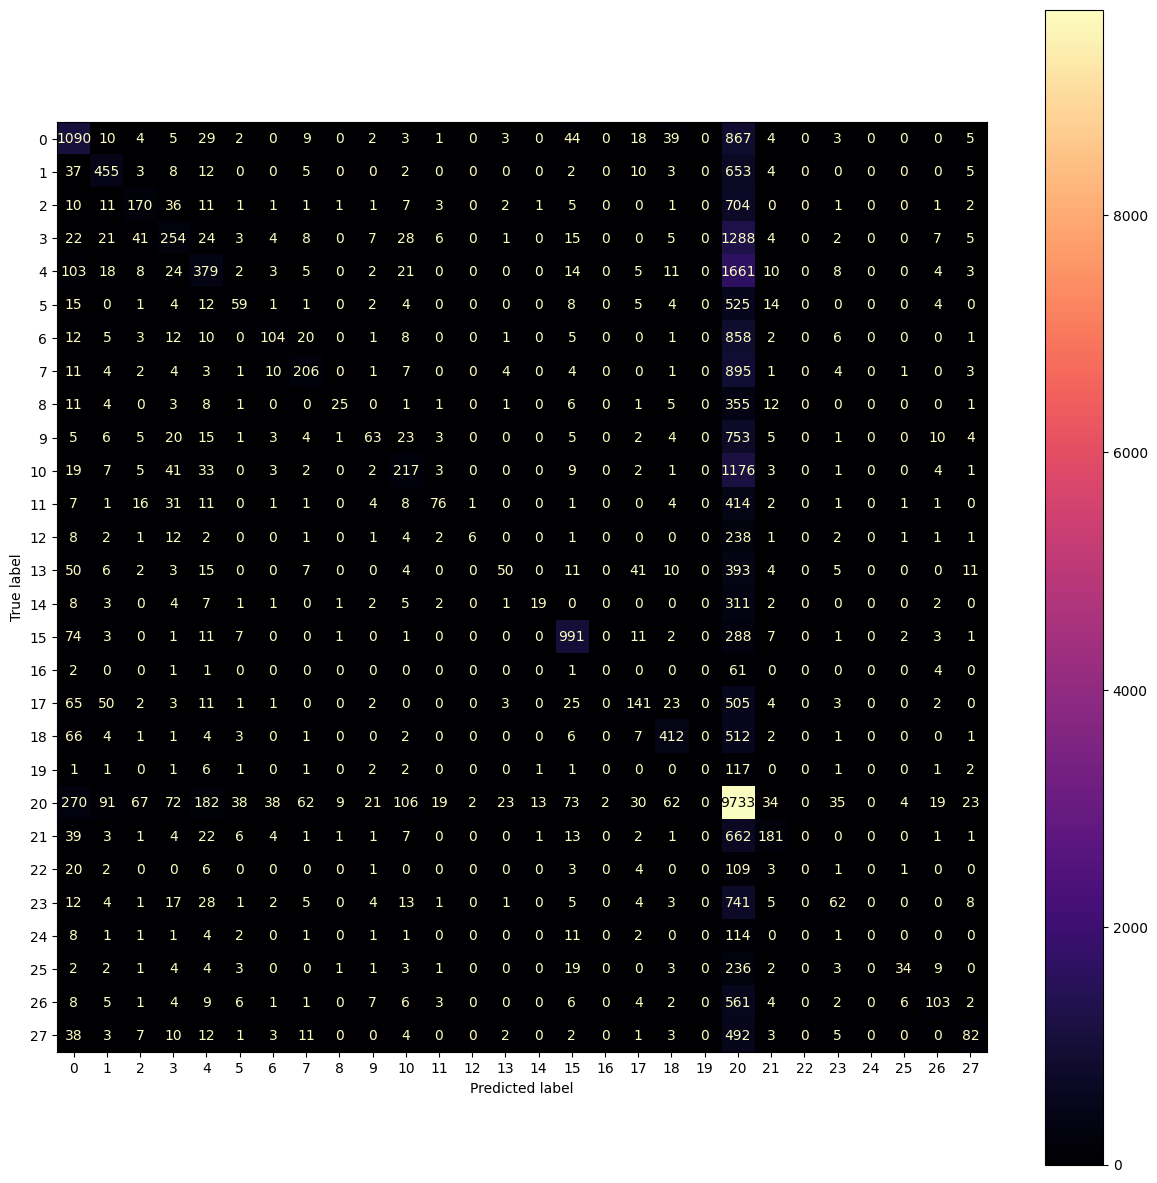

In [152]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.606856012105692
Accuracy: 0.606856012105692
Precision (Weighted): 0.6019247938054093
F1 Score (Weighted): 0.6003860536508596
F1 Score (Macro): 0.5668437205553204
              precision    recall  f1-score   support

           0       0.55      0.33      0.41      3807
           1       0.60      0.59      0.59      7688
           2       0.56      0.57      0.56     11028
           3       0.66      0.75      0.70     11841

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.60      0.61      0.60     34364



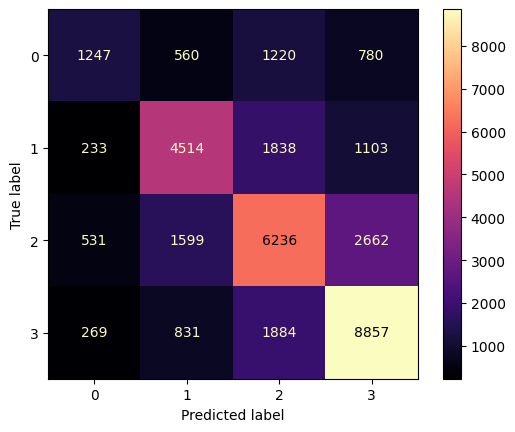

In [153]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [154]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Score for Emotion: 0.5916365964381329
Accuracy: 0.5916365964381329
Precision (Weighted): 0.6092610858995123
F1 Score (Weighted): 0.588901392191954
F1 Score (Macro): 0.5176782882173374
              precision    recall  f1-score   support

           0       0.57      0.80      0.67      2138
           1       0.58      0.81      0.67      1199
           2       0.44      0.72      0.54       970
           3       0.42      0.59      0.49      1745
           4       0.45      0.56      0.50      2281
           5       0.45      0.55      0.50       659
           6       0.50      0.58      0.54      1049
           7       0.55      0.59      0.57      1162
           8       0.52      0.56      0.54       435
           9       0.44      0.47      0.45       933
          10       0.53      0.47      0.49      1529
          11       0.55      0.42      0.48       581
          12       0.50      0.40      0.44       284
          13       0.52      0.45      0.48       612
     

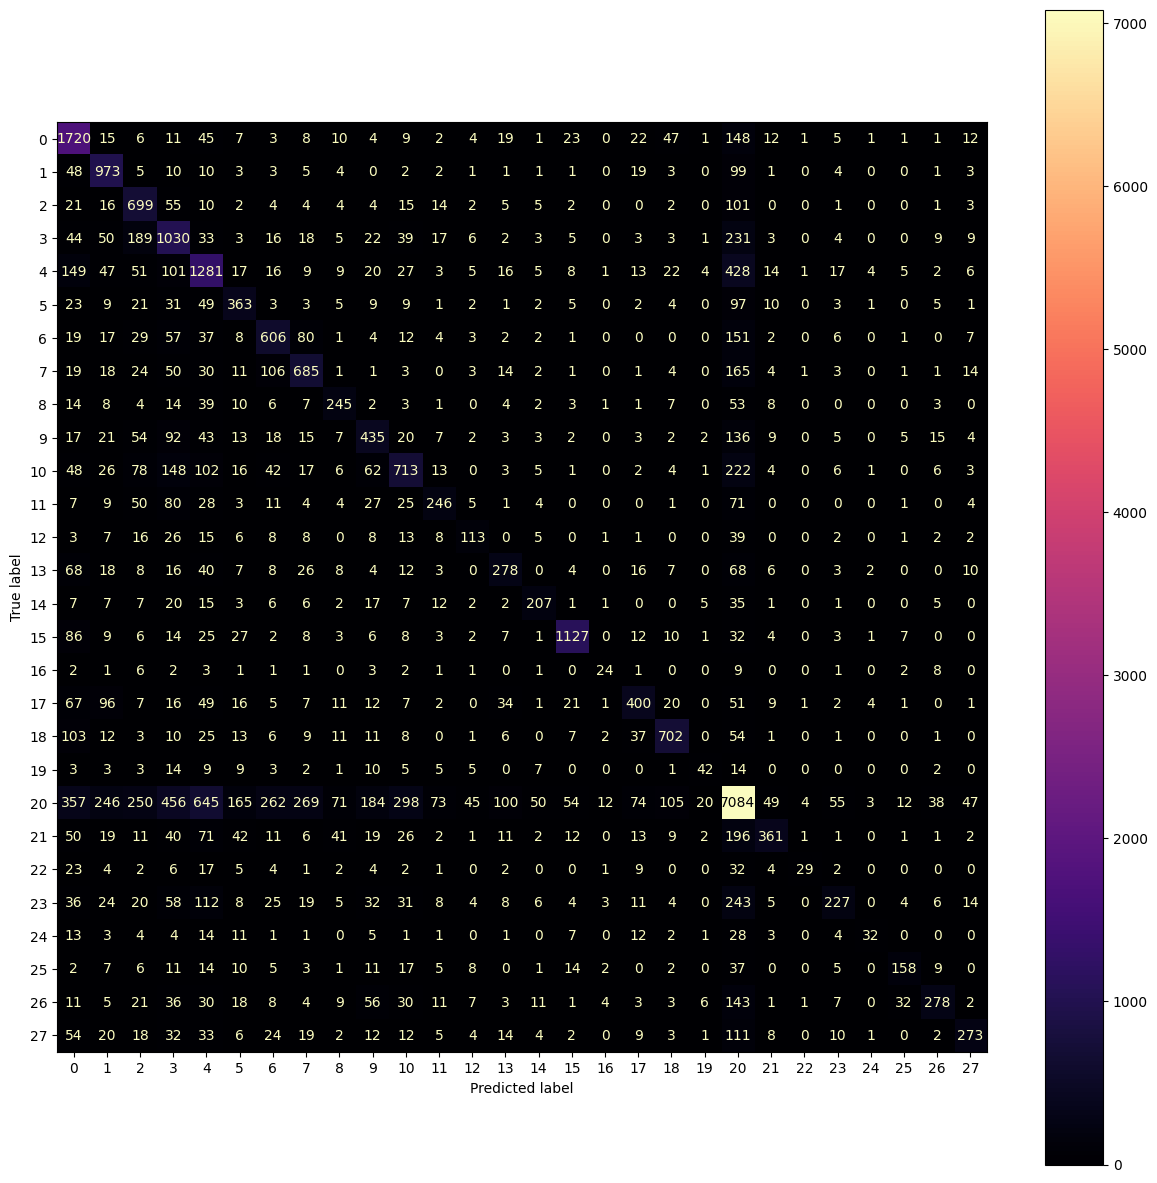

In [155]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7124025142591084
Accuracy: 0.7124025142591084
Precision (Weighted): 0.7242306489172189
F1 Score (Weighted): 0.714701397042487
F1 Score (Macro): 0.7000785834881534
              precision    recall  f1-score   support

           0       0.56      0.72      0.63      3807
           1       0.67      0.77      0.72      7688
           2       0.70      0.66      0.68     11028
           3       0.83      0.72      0.77     11841

    accuracy                           0.71     34364
   macro avg       0.69      0.72      0.70     34364
weighted avg       0.72      0.71      0.71     34364



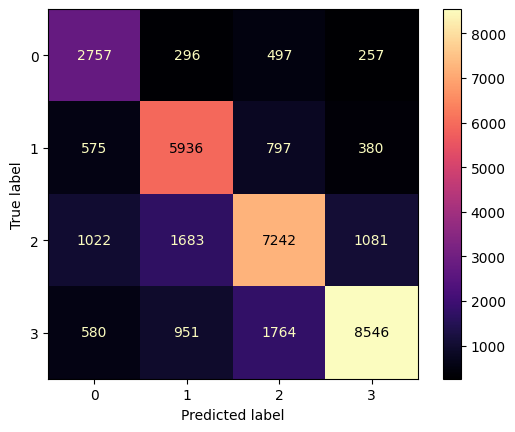

In [156]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [157]:
classifier = MLPClassifier()
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


In [207]:
print(np.shape(X_train))
print(np.shape(yemo_train))

(85910, 30449)
(85910,)


Score for Emotion: 0.5736235595390525
Accuracy: 0.5736235595390525
Precision (Weighted): 0.5670053212126801
F1 Score (Weighted): 0.5678019153950739
F1 Score (Macro): 0.5028894612736048
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2138
           1       0.63      0.66      0.65      1199
           2       0.50      0.50      0.50       970
           3       0.46      0.39      0.42      1745
           4       0.49      0.38      0.43      2281
           5       0.46      0.46      0.46       659
           6       0.53      0.45      0.48      1049
           7       0.56      0.48      0.51      1162
           8       0.44      0.54      0.49       435
           9       0.44      0.38      0.41       933
          10       0.47      0.47      0.47      1529
          11       0.52      0.46      0.49       581
          12       0.44      0.45      0.45       284
          13       0.44      0.41      0.43       612
    

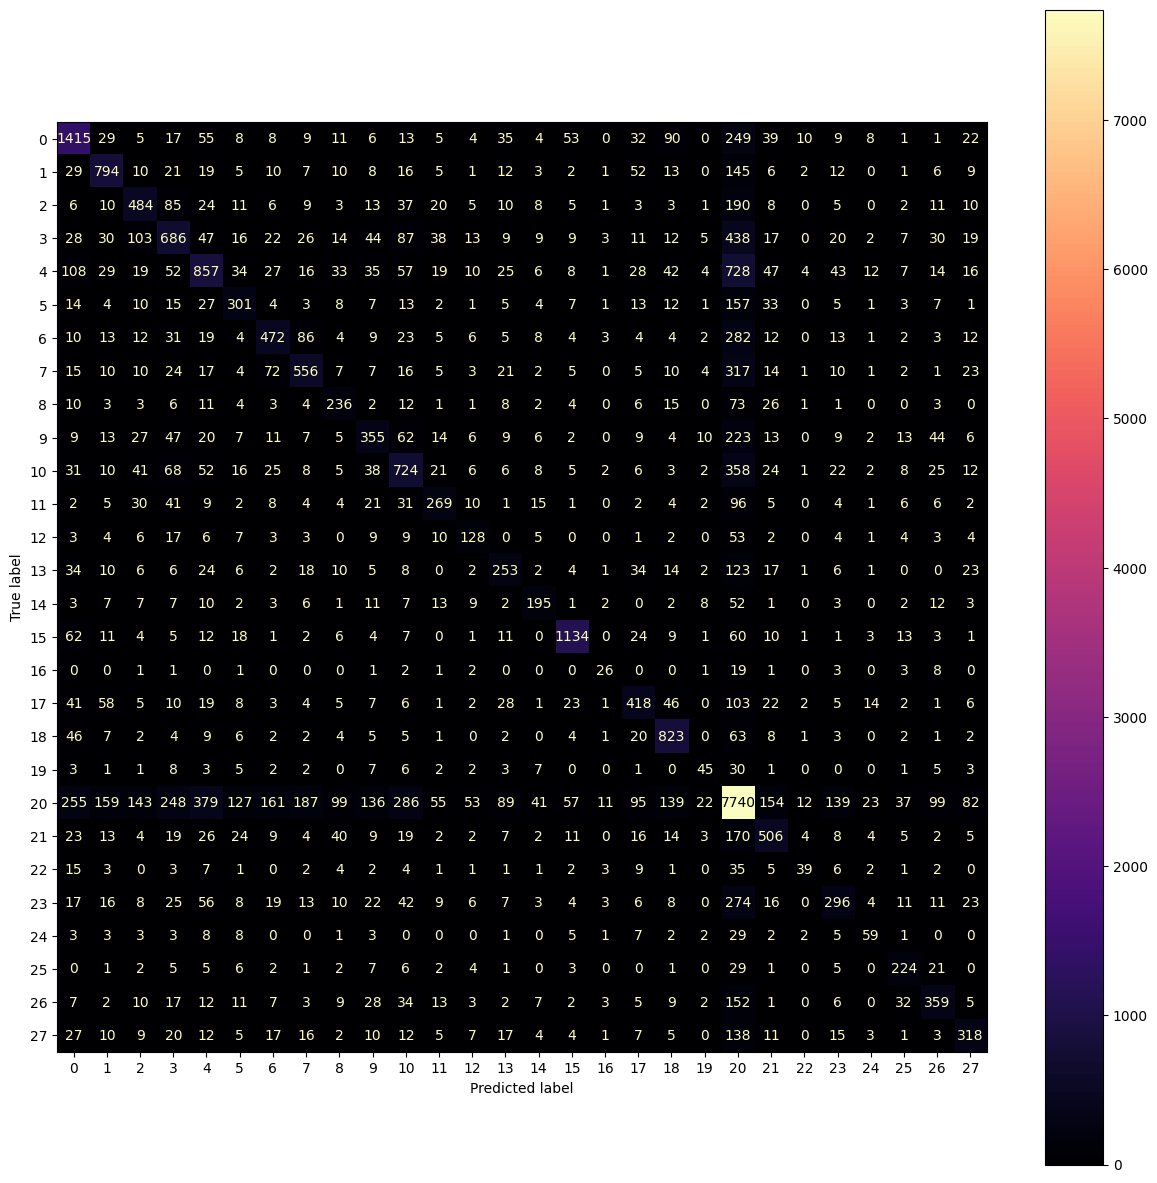

In [158]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.5543301129088581
Accuracy: 0.5543301129088581
Precision (Weighted): 0.5605447325366786
F1 Score (Weighted): 0.5383535316182569
F1 Score (Macro): 0.4775562479168337
              precision    recall  f1-score   support

           0       0.52      0.13      0.20      3807
           1       0.56      0.45      0.50      7688
           2       0.47      0.64      0.54     11028
           3       0.66      0.68      0.67     11841

    accuracy                           0.55     34364
   macro avg       0.55      0.47      0.48     34364
weighted avg       0.56      0.55      0.54     34364



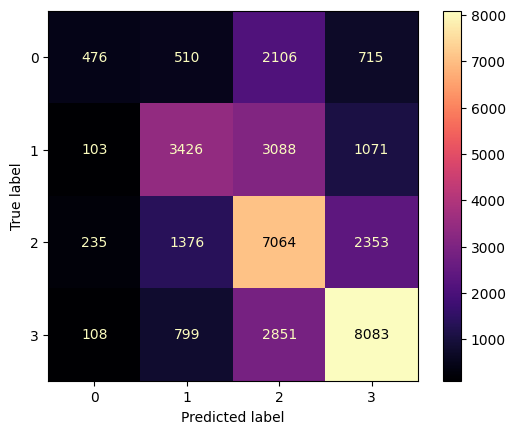

In [159]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [160]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [161]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy: 0.5013386101734373
Precision (Weighted): 0.5084732298280906
F1 Score (Weighted): 0.46044264020407616
F1 Score (Macro): 0.36013186177949025
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      2138
           1       0.60      0.65      0.62      1199
           2       0.46      0.33      0.39       970
           3       0.39      0.20      0.27      1745
           4       0.43      0.19      0.26      2281
           5       0.40      0.20      0.27       659
           6       0.50      0.25      0.34      1049
           7       0.48      0.24      0.32      1162
           8       0.50      0.29      0.37       435
           9       0.46      0.15      0.23       933
          10       0.46      0.23      0.30      1529
          11       0.53      0.26      0.35       581
          12       0.46      0

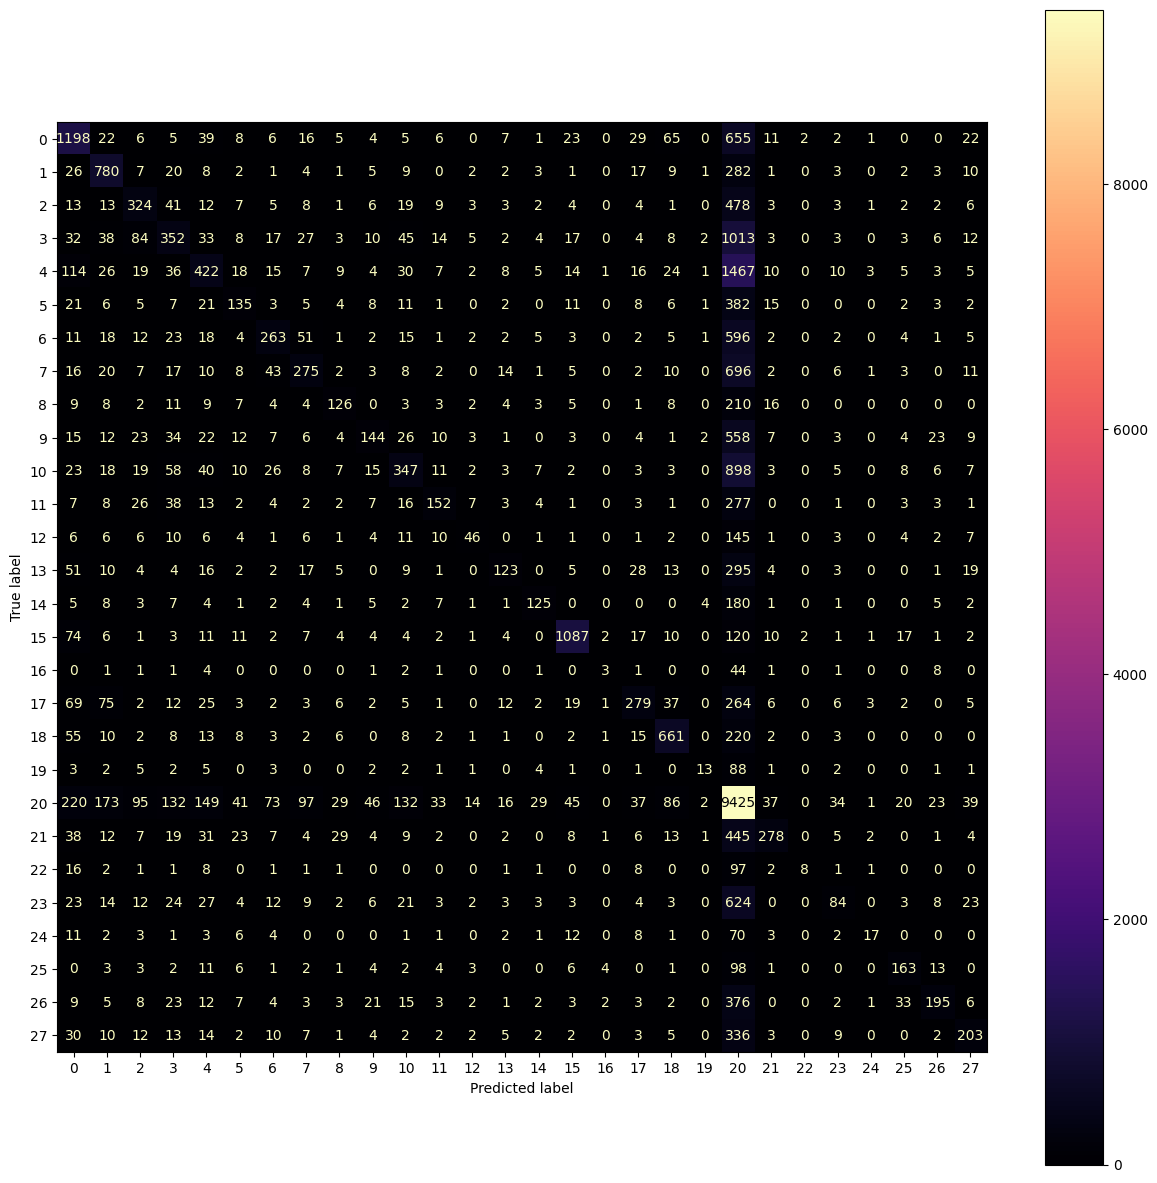

In [162]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy: 0.6149167733674776
Precision (Weighted): 0.661513421845642
F1 Score (Weighted): 0.6167603901074943
F1 Score (Macro): 0.5903915858228655
              precision    recall  f1-score   support

           0       0.53      0.45      0.48      3807
           1       0.69      0.49      0.57      7688
           2       0.50      0.79      0.61     11028
           3       0.84      0.59      0.69     11841

    accuracy                           0.61     34364
   macro avg       0.64      0.58      0.59     34364
weighted avg       0.66      0.61      0.62     34364



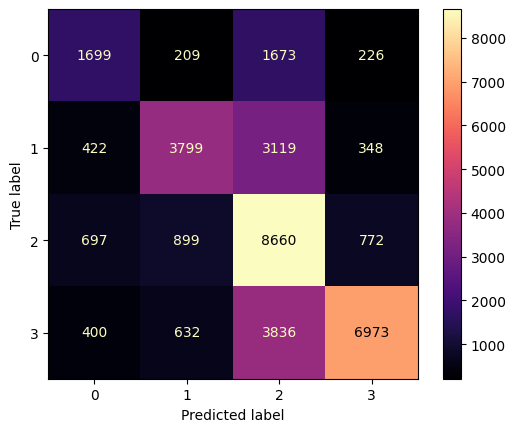

In [163]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [164]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True, verbose=True,max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters,n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 wh

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Accuracy: 0.4526248399487836
Precision (Weighted): 0.4207081616058546
F1 Score (Weighted): 0.3745618513950474
F1 Score (Macro): 0.23883753055314688
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2138
           1       0.53      0.64      0.58      1199
           2       0.39      0.24      0.30       970
           3       0.22      0.05      0.09      1745
           4       0.37      0.10      0.15      2281
           5       0.50      0.00      0.01       659
           6       0.45      0.11      0.17      1049
           7       0.44      0.19      0.26      1162
           8       0.48      0.06      0.11       435
           9       0.00      0.00      0.00       933
          10       0.33      0.12      0.17      1529
          11       0.66      0.05      0.09       581
          12       0.75      0.01      0.02       284
          13       0.58      0.07      0.13       612
          14       0.51      0.35      0.

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2138
           1       0.53      0.64      0.58      1199
           2       0.39      0.24      0.30       970
           3       0.22      0.05      0.09      1745
           4       0.37      0.10      0.15      2281
           5       0.50      0.00      0.01       659
           6       0.45      0.11      0.17      1049
           7       0.44      0.19      0.26      1162
           8       0.48      0.06      0.11       435
           9       0.00      0.00      0.00       933
          10       0.33      0.12      0.17      1529
          11       0.66      0.05      0.09       581
          12       0.75      0.01      0.02       284
          13       0.58      0.07      0.13       612
          14       0.51      0.35      0.41       369
          15       0.74      0.80      0.77      1404
          16       0.00      0.00      0.00        70
          17       0.40    

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


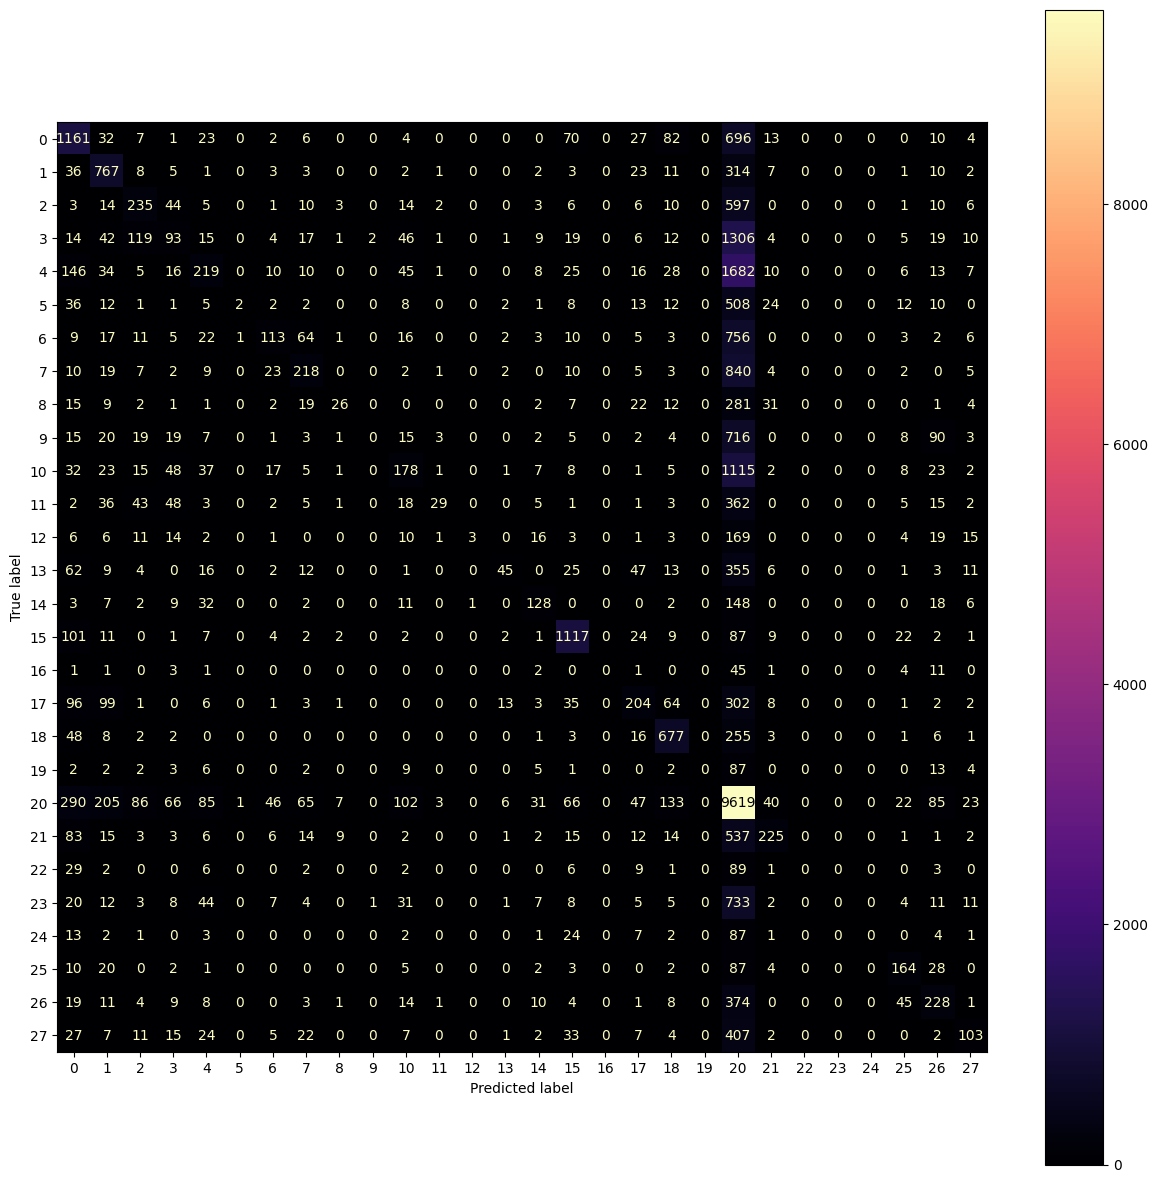

In [165]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6317658014200908
Precision (Weighted): 0.630689856666177
F1 Score (Weighted): 0.6262454919413282
F1 Score (Macro): 0.5905282783828961
              precision    recall  f1-score   support

           0       0.59      0.33      0.43      3807
           1       0.63      0.59      0.61      7688
           2       0.56      0.63      0.60     11028
           3       0.70      0.75      0.73     11841

    accuracy                           0.63     34364
   macro avg       0.62      0.58      0.59     34364
weighted avg       0.63      0.63      0.63     34364

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(5, 10), max_iter=5, verbose=True), Best Score: 0.5612705192148834


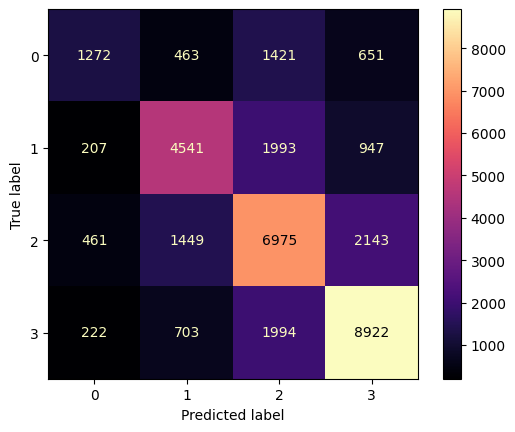

In [166]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>2.5</h3>
Test/Training split: 80/20 -> 50/50
Anticipated effect: increased accuracy but poor generalization


In [167]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [168]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [169]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for Emotion: 0.44799208473984403
Accuracy: 0.44799208473984403
Precision (Weighted): 0.4922571461031896
F1 Score (Weighted): 0.3887147085521164
F1 Score (Macro): 0.24872894849076452


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      5228
           1       0.60      0.43      0.50      3059
           2       0.51      0.21      0.30      2582
           3       0.42      0.17      0.24      4185
           4       0.46      0.19      0.27      5541
           5       0.44      0.13      0.20      1745
           6       0.54      0.13      0.21      2496
           7       0.56      0.19      0.28      2944
           8       0.61      0.08      0.14      1076
           9       0.52      0.09      0.16      2367
          10       0.44      0.17      0.24      3860
          11       0.55      0.14      0.22      1475
          12       0.58      0.03      0.06       712
          13       0.52      0.08      0.14      1534
          14       0.68      0.09      0.16       924
          15       0.77      0.74      0.75      3533
          16       0.00      0.00      0.00       185
          17       0.51    

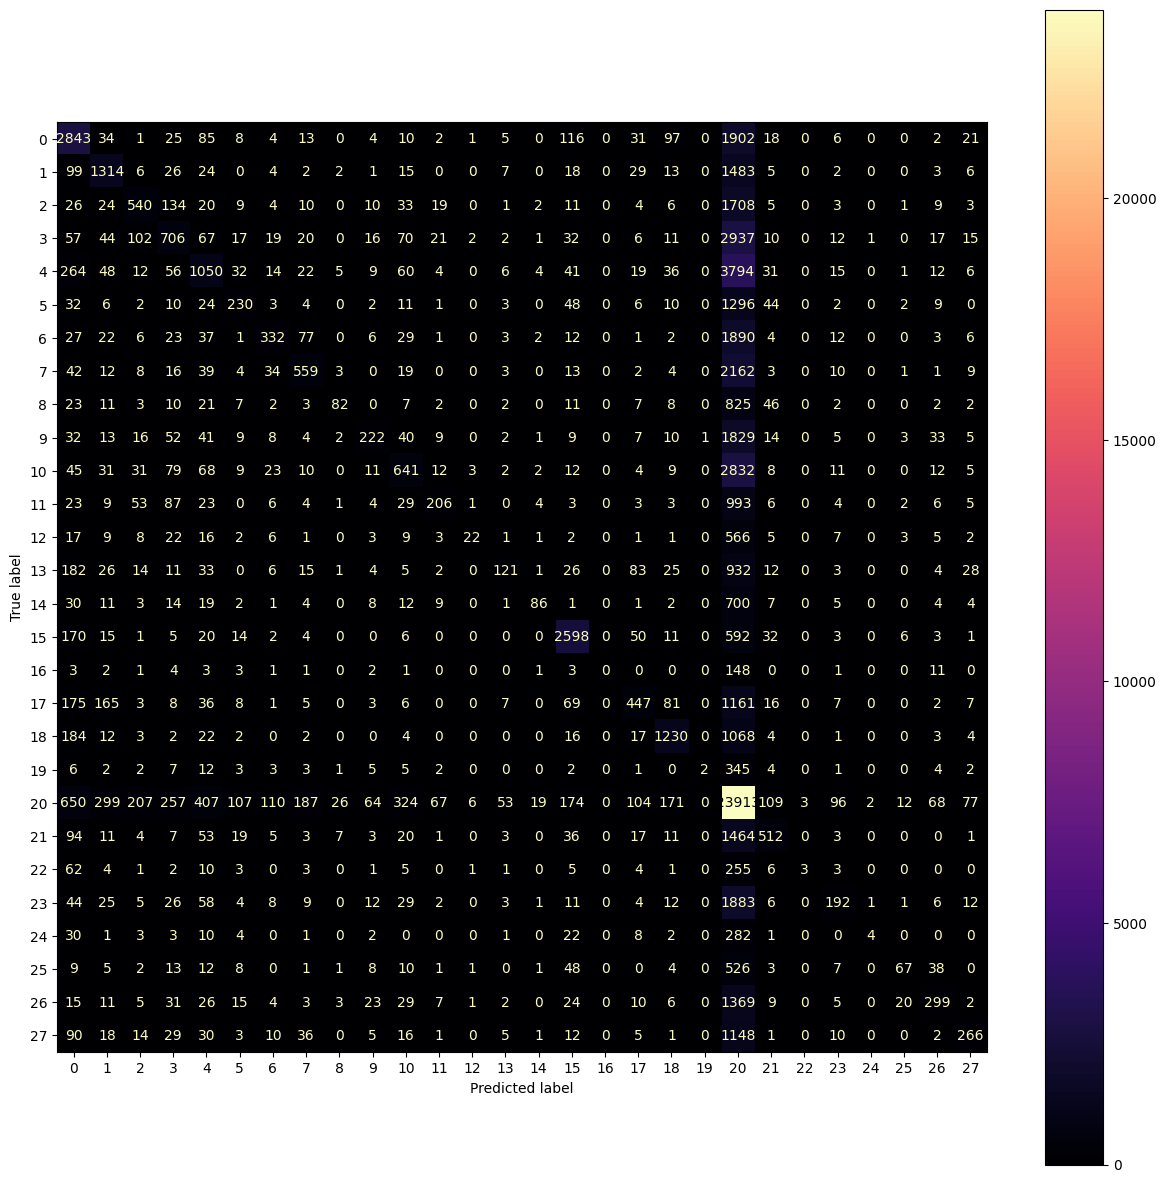

In [170]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6147247119078105
Accuracy: 0.6147247119078105
Precision (Weighted): 0.6096041253338786
F1 Score (Weighted): 0.6087837707793042
F1 Score (Macro): 0.5761648908830871
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      9497
           1       0.61      0.60      0.61     19386
           2       0.57      0.57      0.57     27512
           3       0.67      0.75      0.71     29515

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



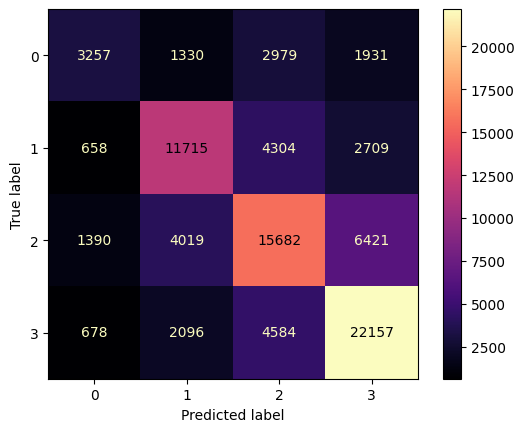

In [171]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [172]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Score for Emotion: 0.6174717727854732
Accuracy: 0.6174717727854732
Precision (Weighted): 0.628302180940379
F1 Score (Weighted): 0.6118005228936239
F1 Score (Macro): 0.5330467504864798
              precision    recall  f1-score   support

           0       0.59      0.82      0.68      5228
           1       0.58      0.83      0.68      3059
           2       0.47      0.71      0.57      2582
           3       0.43      0.59      0.50      4185
           4       0.48      0.54      0.51      5541
           5       0.50      0.59      0.54      1745
           6       0.52      0.56      0.54      2496
           7       0.60      0.61      0.61      2944
           8       0.53      0.53      0.53      1076
           9       0.47      0.43      0.45      2367
          10       0.57      0.49      0.53      3860
          11       0.60      0.42      0.50      1475
          12       0.55      0.36      0.44       712
          13       0.56      0.41      0.48      1534
     

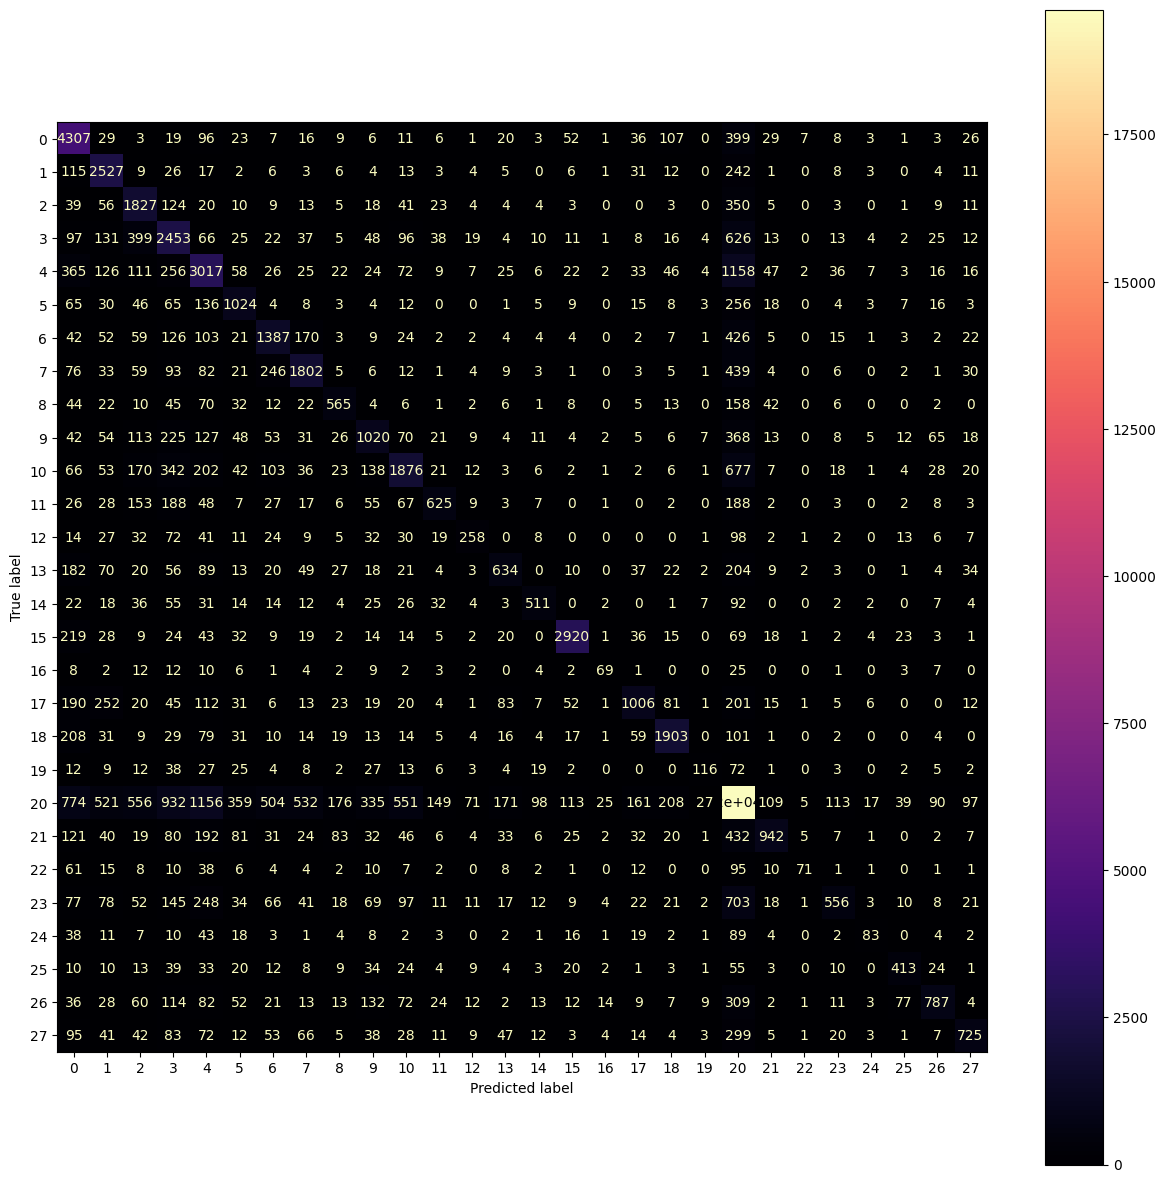

In [173]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7378302875101851
Accuracy: 0.7378302875101851
Precision (Weighted): 0.7445225760580242
F1 Score (Weighted): 0.7394181724390908
F1 Score (Macro): 0.7235552807109272
              precision    recall  f1-score   support

           0       0.60      0.70      0.65      9497
           1       0.70      0.78      0.74     19386
           2       0.72      0.70      0.71     27512
           3       0.84      0.76      0.80     29515

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.72     85910
weighted avg       0.74      0.74      0.74     85910



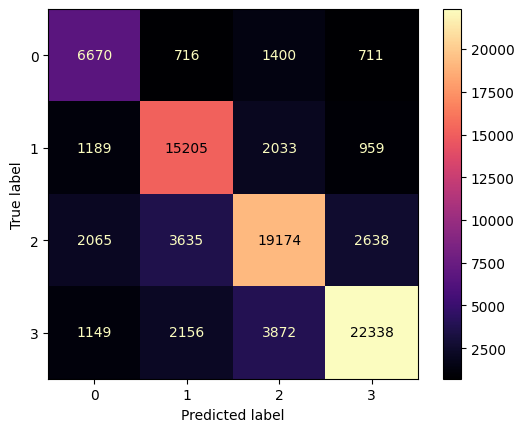

In [174]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [175]:
classifier = MLPClassifier()
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


pickle file used
pickle file used


Score for Emotion: 0.5958561285065767
Accuracy: 0.5958561285065767
Precision (Weighted): 0.5878296716875615
F1 Score (Weighted): 0.5873010707285921
F1 Score (Macro): 0.5208603689069158
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      5228
           1       0.65      0.71      0.68      3059
           2       0.58      0.47      0.52      2582
           3       0.49      0.40      0.44      4185
           4       0.54      0.37      0.44      5541
           5       0.52      0.48      0.50      1745
           6       0.57      0.41      0.47      2496
           7       0.58      0.56      0.57      2944
           8       0.46      0.55      0.50      1076
           9       0.49      0.35      0.41      2367
          10       0.53      0.47      0.50      3860
          11       0.51      0.46      0.48      1475
          12       0.40      0.49      0.44       712
          13       0.48      0.42      0.45      1534
    

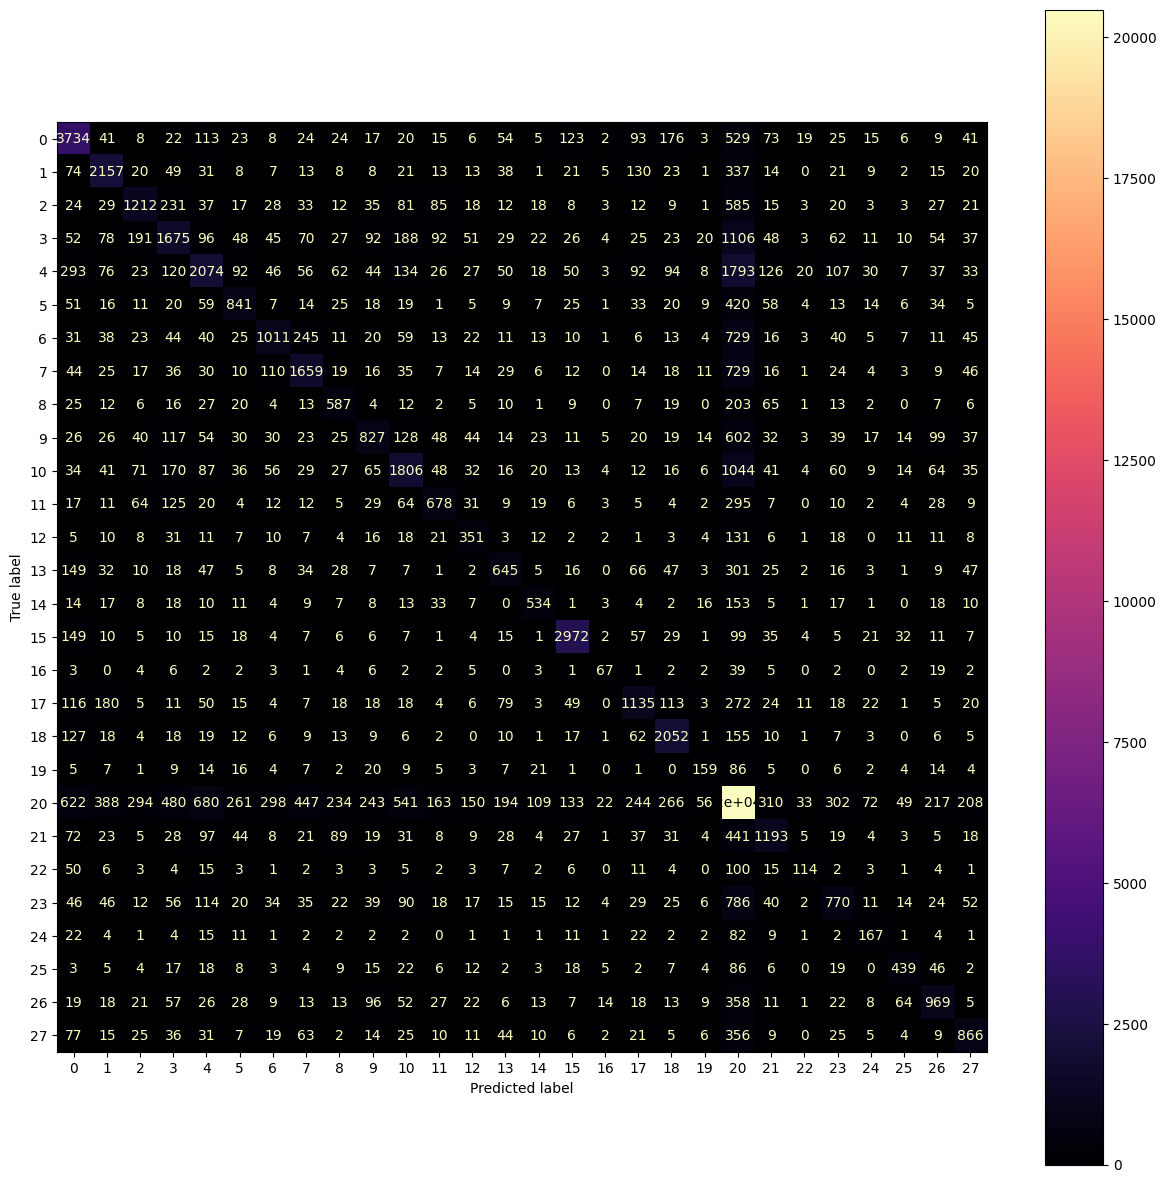

In [176]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

Score for Sentiment: 0.7254452333837738
Accuracy: 0.7254452333837738
Precision (Weighted): 0.7244157170003341
F1 Score (Weighted): 0.7246456786378265
F1 Score (Macro): 0.7047144218679494
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      9497
           1       0.71      0.73      0.72     19386
           2       0.69      0.69      0.69     27512
           3       0.79      0.80      0.79     29515

    accuracy                           0.73     85910
   macro avg       0.71      0.70      0.70     85910
weighted avg       0.72      0.73      0.72     85910



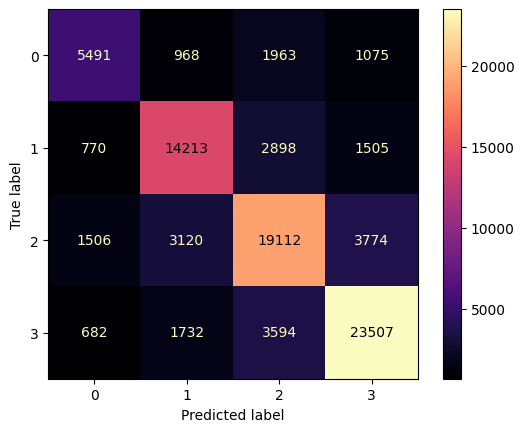

In [177]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [178]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy: 0.48398323827261086
Precision (Weighted): 0.4867247672011724
F1 Score (Weighted): 0.45323621533090636
F1 Score (Macro): 0.3424190455374923
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      5228
           1       0.59      0.60      0.59      3059
           2       0.49      0.33      0.40      2582
           3       0.41      0.25      0.31      4185
           4       0.44      0.25      0.32      5541
           5       0.39      0.28      0.32      1745
           6       0.46      0.24      0.31      2496
           7       0.51      0.31      0.39      2944
           8       0.51      0.19      0.28      1076
           9       0.46      0.18      0.26      2367
          10       0.42      0.27      0.33      3860
          11       0.51      0.27      0.35      1475
          12       0.53      0.11      0.19       712
          1

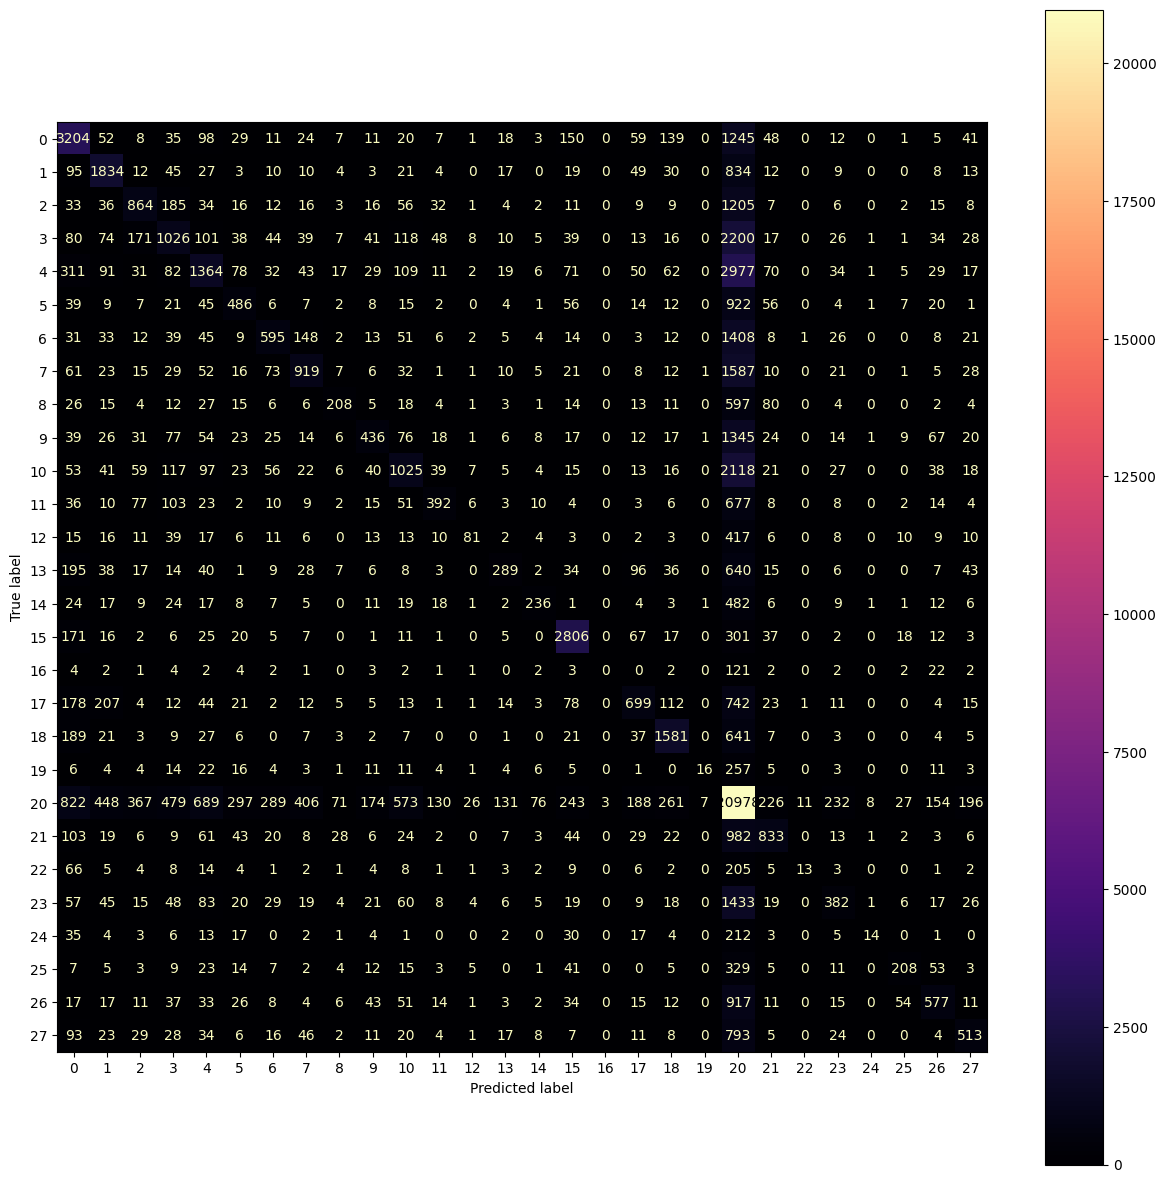

In [179]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy: 0.6147247119078105
Precision (Weighted): 0.6096041253338786
F1 Score (Weighted): 0.6087837707793042
F1 Score (Macro): 0.5761648908830871
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      9497
           1       0.61      0.60      0.61     19386
           2       0.57      0.57      0.57     27512
           3       0.67      0.75      0.71     29515

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



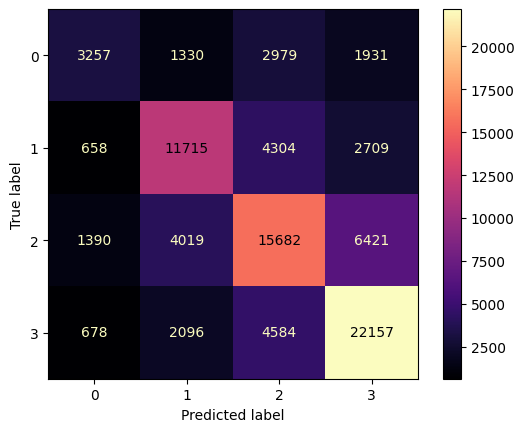

In [180]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [181]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy: 0.4689093237108602
Precision (Weighted): 0.4588270689284768
F1 Score (Weighted): 0.4235045966252807
F1 Score (Macro): 0.31931924049553567
              precision    recall  f1-score   support

           0       0.55      0.52      0.54      5228
           1       0.56      0.59      0.58      3059
           2       0.44      0.26      0.33      2582
           3       0.30      0.16      0.21      4185
           4       0.34      0.15      0.21      5541
           5       0.34      0.14      0.20      1745
           6       0.40      0.19      0.26      2496
           7       0.48      0.23      0.31      2944
           8       0.43      0.26      0.32      1076
           9       0.33      0.13      0.19      2367
          10       0.33      0.15      0.21      3860
          11       0.43      0.21      0.28      1475
          12       0.44      0.

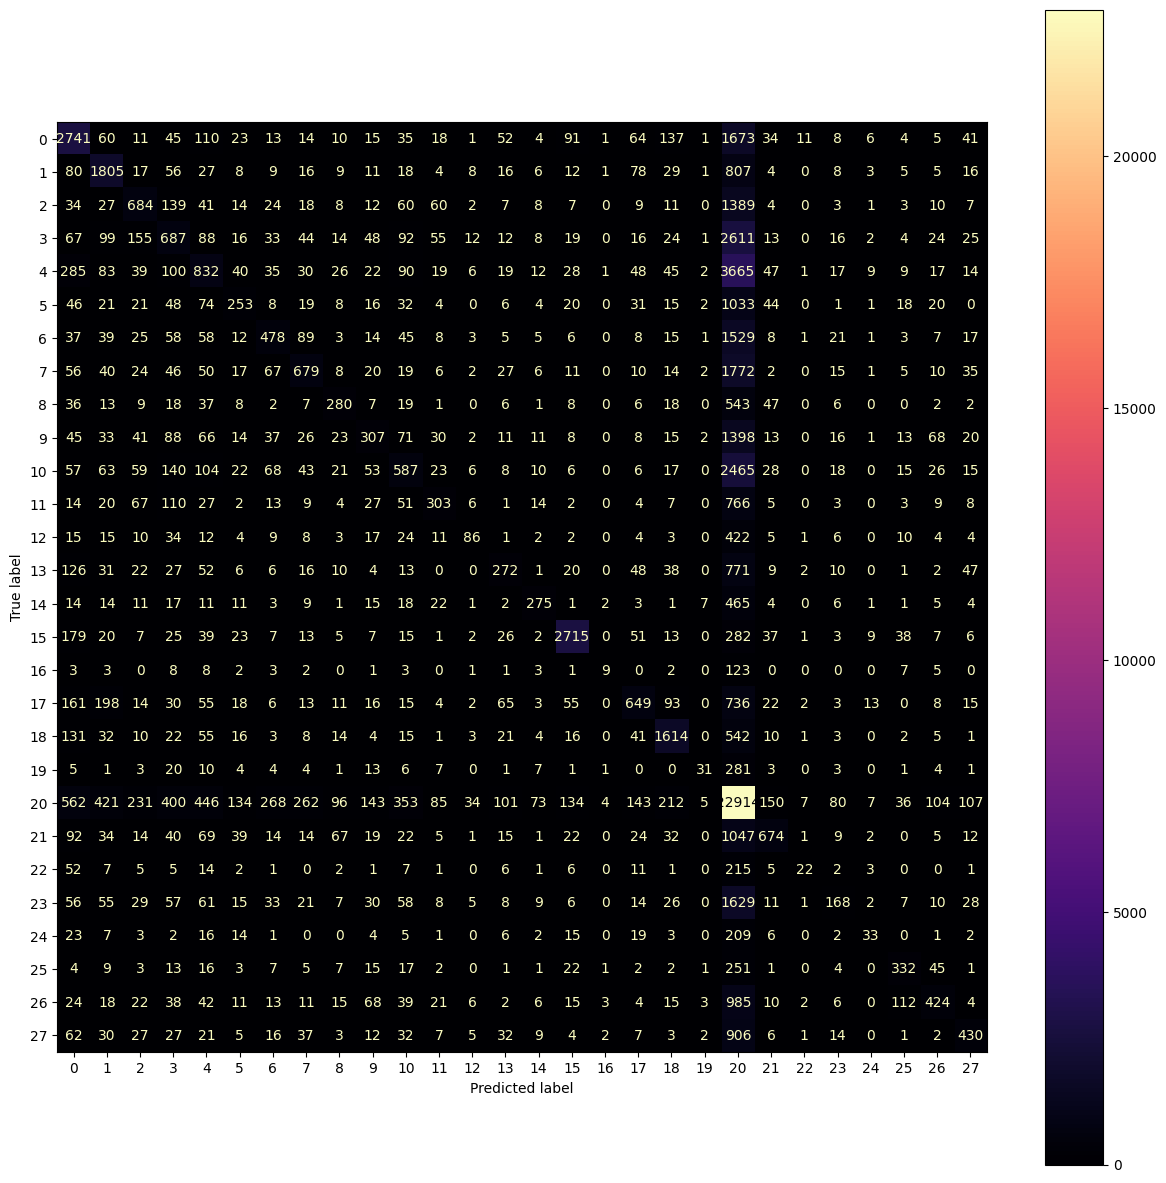

In [182]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy: 0.5839250378302875
Precision (Weighted): 0.6296687835807132
F1 Score (Weighted): 0.582266132254776
F1 Score (Macro): 0.5489886888866826
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      9497
           1       0.65      0.45      0.53     19386
           2       0.47      0.78      0.59     27512
           3       0.80      0.57      0.67     29515

    accuracy                           0.58     85910
   macro avg       0.61      0.53      0.55     85910
weighted avg       0.63      0.58      0.58     85910



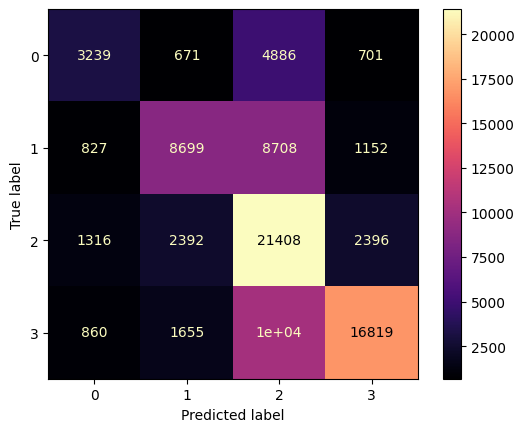

In [183]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [184]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.2 wh

Accuracy: 0.434990105924805
Precision (Weighted): 0.38392154921549065
F1 Score (Weighted): 0.34280870427683313
F1 Score (Macro): 0.20280309389144055


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

              precision    recall  f1-score   support

           0       0.47      0.54      0.50      5228
           1       0.55      0.62      0.58      3059
           2       0.39      0.09      0.15      2582
           3       0.22      0.01      0.03      4185
           4       0.42      0.06      0.10      5541
           5       0.22      0.04      0.07      1745
           6       0.35      0.10      0.15      2496
           7       0.28      0.14      0.18      2944
           8       0.41      0.14      0.21      1076
           9       0.00      0.00      0.00      2367
          10       0.25      0.01      0.02      3860
          11       0.57      0.10      0.17      1475
          12       1.00      0.00      0.00       712
          13       0.33      0.01      0.03      1534
          14       0.00      0.00      0.00       924
          15       0.81      0.78      0.79      3533
          16       0.00      0.00      0.00       185
          17       0.35    

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.47      0.54      0.50      5228
           1       0.55      0.62      0.58      3059
           2       0.39      0.09      0.15      2582
           3       0.22      0.01      0.03      4185
           4       0.42      0.06      0.10      5541
           5       0.22      0.04      0.07      1745
           6       0.35      0.10      0.15      2496
           7       0.28      0.14      0.18      2944
           8       0.41      0.14      0.21      1076
           9       0.00      0.00      0.00      2367
          10       0.25      0.01      0.02      3860
          11       0.57      0.10      0.17      1475
          12       1.00      0.00      0.00       712
          13       0.33      0.01      0.03      1534
          14       0.00      0.00      0.00       924
          15       0.81      0.78      0.79      3533
          16       0.00      0.00      0.00       185
          17       0.35    

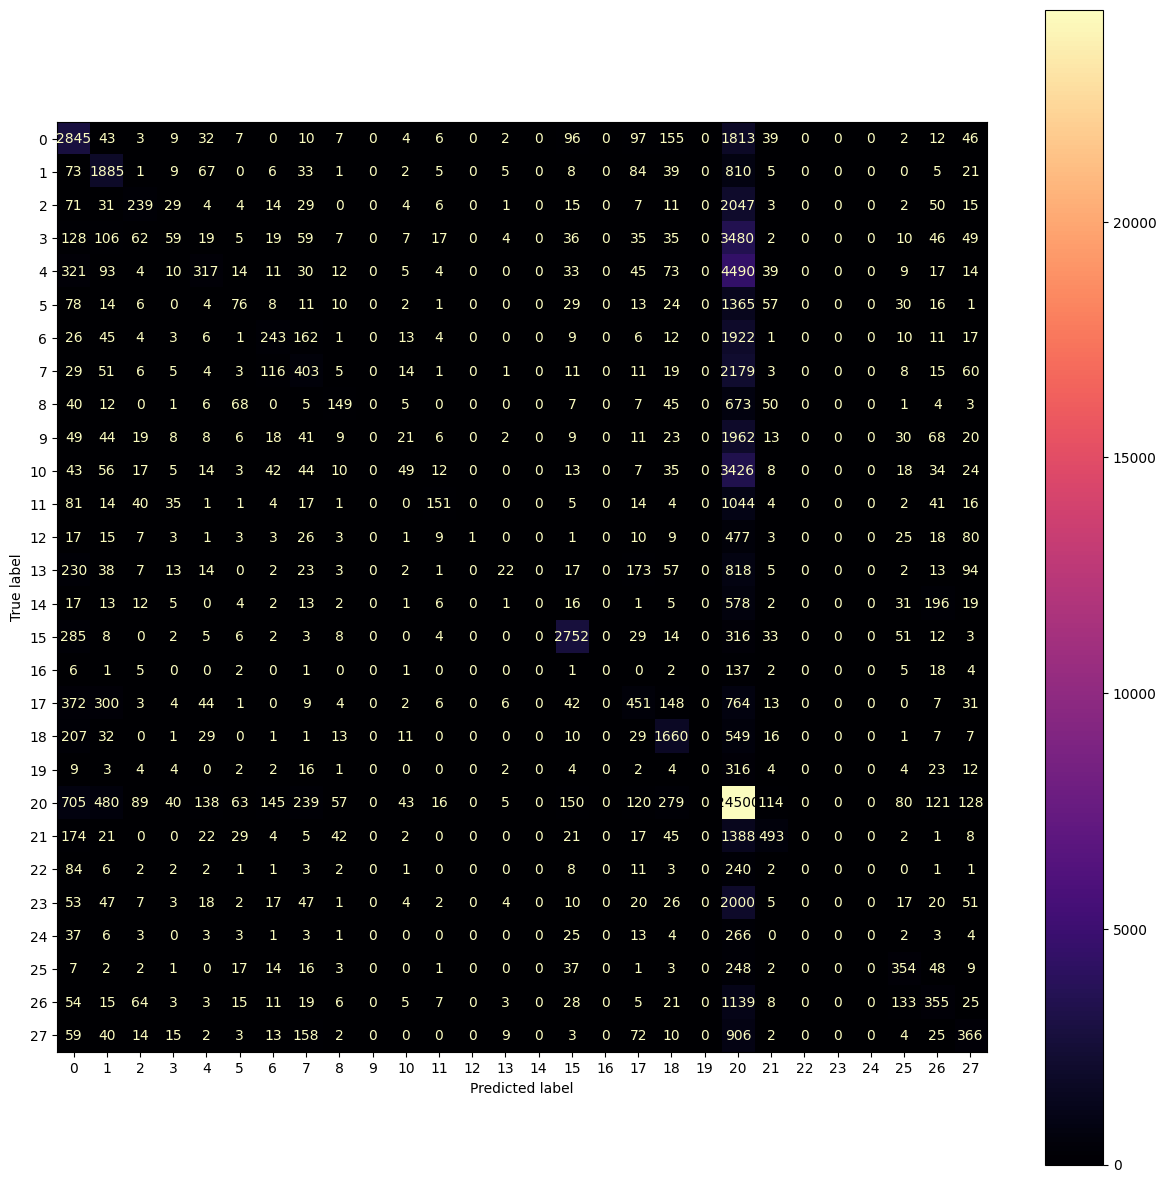

In [185]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6028751018507741
Precision (Weighted): 0.602930245884122
F1 Score (Weighted): 0.599255394296677
F1 Score (Macro): 0.5620974799782961
              precision    recall  f1-score   support

           0       0.51      0.32      0.39      9497
           1       0.59      0.57      0.58     19386
           2       0.53      0.61      0.57     27512
           3       0.71      0.71      0.71     29515

    accuracy                           0.60     85910
   macro avg       0.59      0.55      0.56     85910
weighted avg       0.60      0.60      0.60     85910

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(5, 5),
              max_iter=5, verbose=True), Best Score: 0.5505296240251426


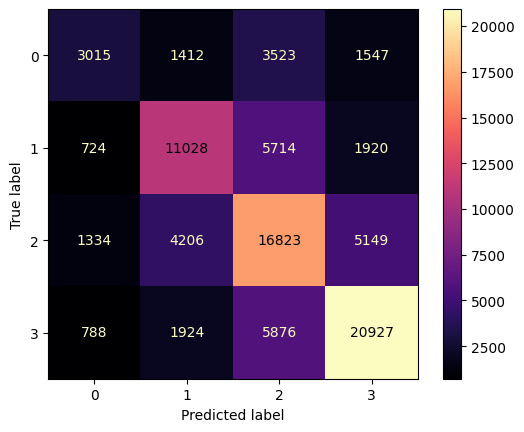

In [186]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [187]:
# result.most_similar("cat")

In [188]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
print(np.shape(post))

pickle file used
(171820,)


In [189]:
nltk.download('punkt')
#post.str.lower()
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\girou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [190]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
print("Number of tokens in Reddit posts:")
tokens_list = []
for i in post_tokens:
    for j in i:
        tokens_list.append(j)
print(len(tokens_list))

Number of tokens in Reddit posts:
2642128


In [191]:
X_embed_train,X_embed_test, y_embed_emotions_train, y_embed_emotions_test, y_embed_sentiments_train, y_embed_sentiments_test= train_test_split(post_tokens, encodedEmo, encodedSentiment, test_size = 0.2, train_size=0.8)

In [192]:
# average_embedding_training = []
# average_embedding_test = []
# average_embedding_total = []
# key_error = False
# missed = 0
# # model = gensim.models
model = gensim.downloader.load("word2vec-google-news-300")

# for post in X_train_emb:
#     token_embeddings = []
#     for words in post:
#         key_error = False
#         try:
#             token_embeddings.append(model[words])
#         except KeyError:
#             key_error = True
#             missed = missed + 1
#     average_embedding_training.append(np.mean(token_embeddings,axis=0))

# print('Hit rate of training set:')
# print(1 - (missed/len(tokens_list)))
    
# missed=0
    
# for post in X_test_emb:
#     token_embeddings = []
#     for words in post:
#         key_error = False
#         try:
#             token_embeddings.append(model[words])
#         except KeyError:
#             key_error = True
#             missed = missed + 1
#     average_embedding_test.append(np.mean(token_embeddings,axis=0))

# print('Hit rate of test set:')
# print(1 - (missed/len(tokens_list)))

# for i in range(len(average_embedding_training)):
#     average_embedding_training[i] = np.array(average_embedding_training[i])
# for i in range(len(average_embedding_test)):
#     average_embedding_test[i] = np.array(average_embedding_test[i])


posts_tokens_in_model_training = [] # List of posts but with only the tokens that are in the model
number_tokens_after_removal_training = 0
# Removing words that are not in the Google model
for post in X_embed_train:
    post_with_unmodeled_words_removed_train = [] # Post with the unmodeled words removed
    for word in post:
        if word in model:
            post_with_unmodeled_words_removed_train.append(word)
        else:
            continue
    posts_tokens_in_model_training.append(post_with_unmodeled_words_removed_train)
    number_tokens_after_removal_training += len(post_with_unmodeled_words_removed_train)

# Calculating the average embed for each post in the training set
average_embeds_train = []
for post in posts_tokens_in_model_training:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) # Get the embedding for each word in the post, model[word] returns the embedding for the word
    # axis = 0 means that we are averaging the rows
    average_embeds_train.append(np.mean(token_embeddings,axis=0)) # use np.mean() to get the average of the embeddings for the words in the post


# ~~~~~~~~~~~Test set:
posts_tokens_in_model_test = [] # List of posts but with only the tokens that are in the model
number_tokens_after_removal_test = 0
# Removing words that are not in the Google model
for post in X_embed_test:
    post_with_unmodeled_words_removed_test = [] # Post with the unmodeled words removed
    for word in post:
        if word in model:
            post_with_unmodeled_words_removed_test.append(word)
        else:
            continue
    posts_tokens_in_model_test.append(post_with_unmodeled_words_removed_test)
    number_tokens_after_removal_test += len(post_with_unmodeled_words_removed_test)
    
# Calculating the average embed for each post in the test set
average_embeds_test = []
for post in posts_tokens_in_model_test:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) # Get the embedding for each word in the post, model[word] returns the embedding for the word
    average_embeds_test.append(np.mean(token_embeddings,axis=0)) # use np.mean() to get the average of the embeddings for the words in the post

# Setting the training and test sets to the average embeddings
X_embed_avg_train = average_embeds_train
X_embed_avg_test = average_embeds_test

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [193]:
#Remove empty posts from training and test sets and the corresponding labels

print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
print(np.shape(y_embed_emotions_test))

# Remove all empty posts from the training set (if the shape isn't 300 it's bad!)
for i in range(len(X_embed_avg_train)):
    if i >= len(X_embed_avg_train):
        break
    if X_embed_avg_train[i].shape == (300,):
        continue
    else:
        X_embed_avg_train.pop(i)
        y_embed_emotions_train = np.delete(y_embed_emotions_train, i)
        y_embed_sentiments_train = np.delete(y_embed_sentiments_train, i)

# Remove all empty posts from the test set (if the shape isn't 300 it's bad!)
for i in range(len(X_embed_avg_test)):
    if i >= len(X_embed_avg_test):
        break
    if X_embed_avg_test[i].shape == (300,):
        continue
    else:
        X_embed_avg_test.pop(i)
        y_embed_emotions_test = np.delete(y_embed_emotions_test, i)
        y_embed_sentiments_test = np.delete(y_embed_sentiments_test, i)

#print shape of training and test sets
print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
print(np.shape(y_embed_emotions_test))

# Turn all the posts into regular np arrays since otherwise we get: ValueError: Setting an array element with a sequence.
for i in range(len(X_embed_avg_train)):
    X_embed_avg_train[i] = np.array(X_embed_avg_train[i])

for i in range(len(X_embed_avg_test)):
    X_embed_avg_test[i] = np.array(X_embed_avg_test[i])

C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Shape of test set: (34364,)
(34364,)
Shape of training set: (137394, 300)
Shape of test set: (34339, 300)
(34339,)


In [194]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [221]:
# classifier = MLPClassifier()
classifier = MLPClassifier(max_iter=3)

if (os.path.exists('models/Embeddings_MLP_model.pickle')):
    pickle_in = open('models/Embeddings_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP = classifier.fit(X_embed_avg_train, y_embed_emotions_train)
    with open('models/Embeddings_MLP_model.pickle','wb') as f:
            pickle.dump(EMLP, f)
    pickle_in = open('models/Embeddings_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

        
if (os.path.exists('models/Embeddings_MLP_model2.pickle')):
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP2 = classifier.fit(X_embed_avg_train, y_embed_sentiments_train)
    with open('models/Embeddings_MLP_model2.pickle','wb') as f:
            pickle.dump(EMLP2, f)
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [208]:
print(np.shape(X_embed_avg_train))
print(np.shape(y_embed_emotions_train))

(137394, 300)
(137394,)


Score for Emotions: 0.4013221118844463
Accuracy: 0.4013221118844463
Precision (Weighted): 0.3754376117501321
F1 Score (Weighted): 0.30584508635836427
F1 Score (Macro): 0.17166754639718212


C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\girou\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

              precision    recall  f1-score   support

           0       0.47      0.40      0.43      2069
           1       0.46      0.38      0.41      1202
           2       0.33      0.16      0.22       983
           3       0.26      0.03      0.05      1688
           4       0.30      0.02      0.03      2276
           5       0.35      0.06      0.10       688
           6       0.65      0.01      0.03      1002
           7       0.35      0.09      0.15      1156
           8       0.56      0.06      0.11       415
           9       0.28      0.01      0.01       931
          10       0.28      0.05      0.08      1578
          11       0.41      0.09      0.15       602
          12       0.00      0.00      0.00       293
          13       0.35      0.03      0.06       631
          14       0.41      0.07      0.13       365
          15       0.73      0.74      0.74      1407
          16       0.00      0.00      0.00        63
          17       0.33    

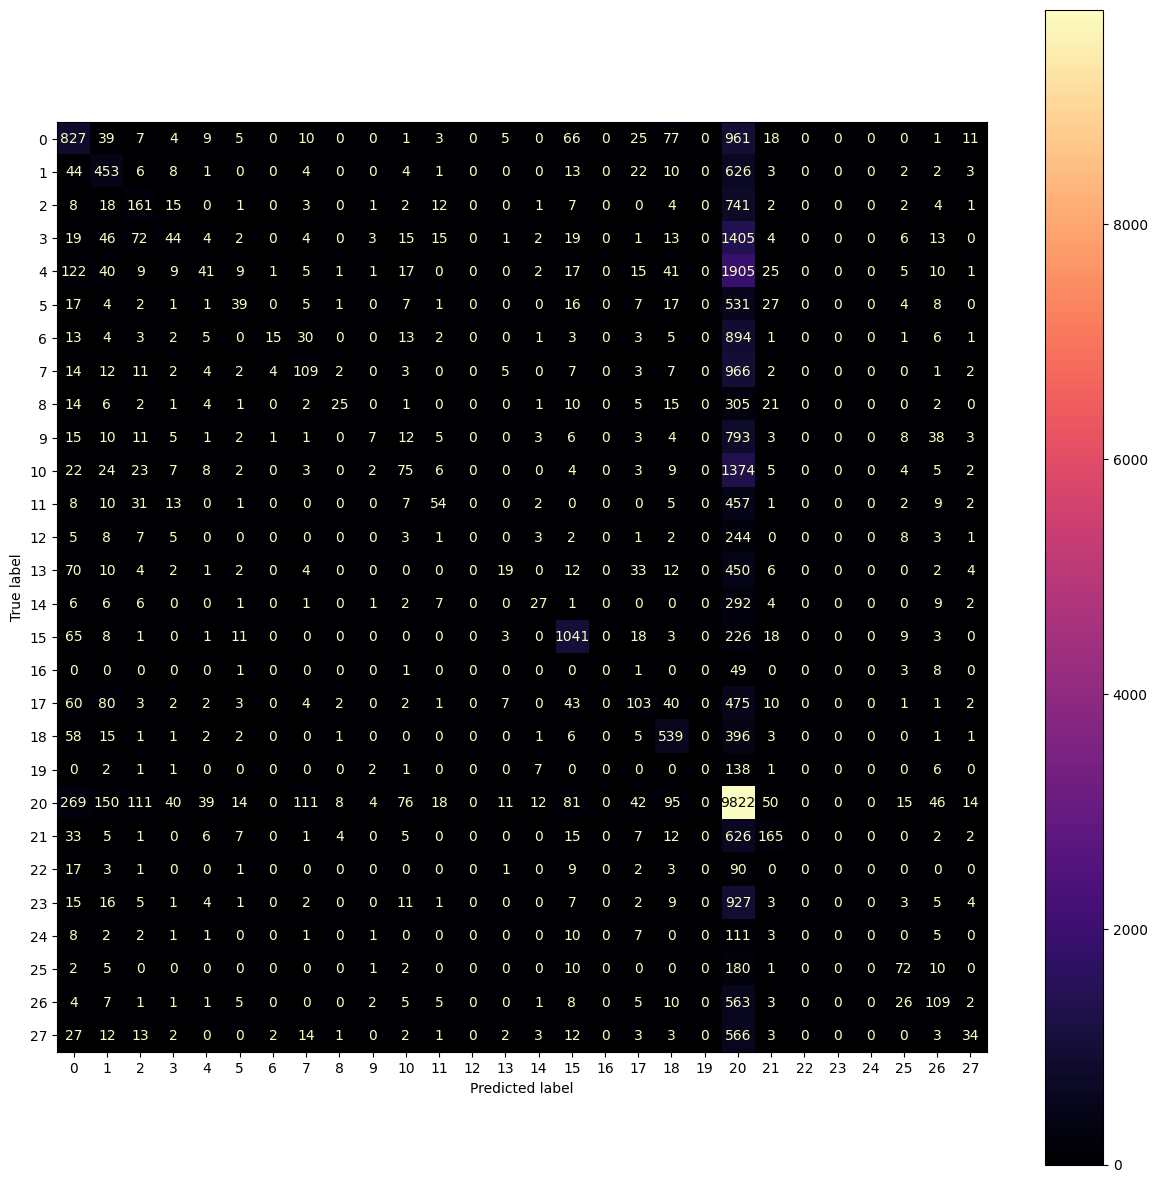

In [227]:
y_emo_predict = clf1.predict(X_embed_avg_test)
print(f"Score for Emotions: {clf1.score(X_embed_avg_test, y_embed_emotions_test)}")
metrics(y_embed_emotions_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_embed_emotions_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiments: 0.5315239232359708
Accuracy: 0.5315239232359708
Precision (Weighted): 0.5309111996543238
F1 Score (Weighted): 0.5149195740169507
F1 Score (Macro): 0.45823260733814664
              precision    recall  f1-score   support

           0       0.48      0.12      0.20      3877
           1       0.53      0.43      0.47      7703
           2       0.46      0.60      0.52     11028
           3       0.61      0.67      0.64     11731

    accuracy                           0.53     34339
   macro avg       0.52      0.46      0.46     34339
weighted avg       0.53      0.53      0.51     34339



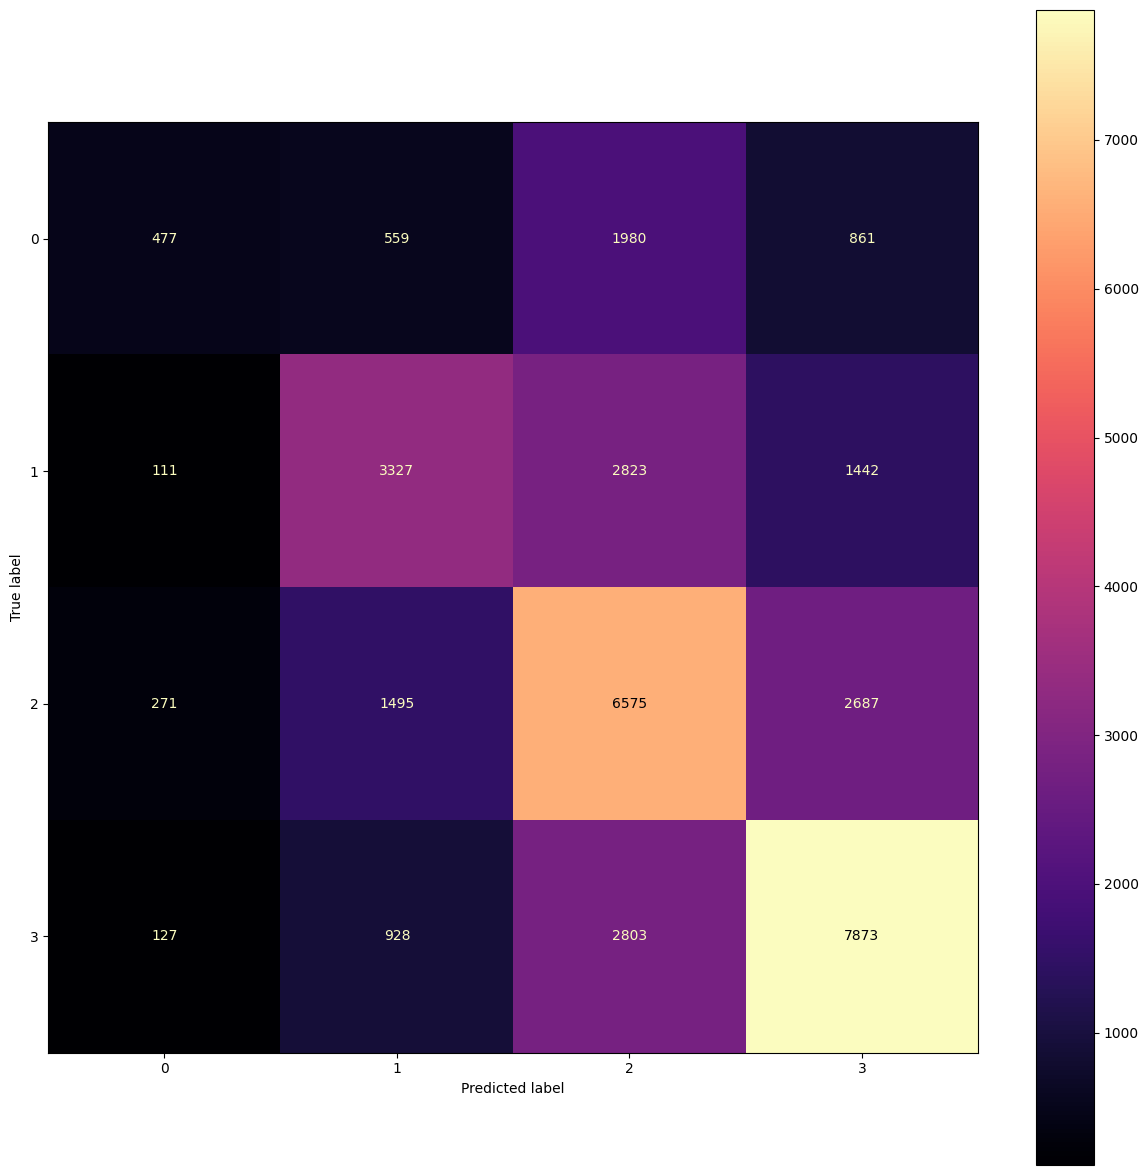

In [228]:
y_sent_predict = clf2.predict(X_embed_avg_test)
print(f"Score for Sentiments: {clf2.score(X_embed_avg_test, y_embed_sentiments_test)}")
metrics(y_embed_sentiments_test, y_sent_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_embed_sentiments_test, y_pred=y_sent_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

In [229]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        X_embed_avg_train, y_embed_emotions_train
        classifier = classifier.fit(X_embed_avg_train, y_embed_emotions_train)
        with open('models/new_split/MLP1GridCV_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_embed_avg_train,y_embed_sentiments_train)
        with open('models/new_split/MLP2GridCV_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

KeyboardInterrupt: 